# Imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os

from addict import Dict
import json

from datetime import timedelta, datetime

from matplotlib.patches import Rectangle


In [8]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot
import akta

import hplc_data_processing as hplc

# HCCF

In [105]:
# Load HPLC data
file_path = f'./hplc_data/2022-07-23_HCCF_on_bare_agarose/'
data, sample_ids = hplc.load_hplc_data(file_path, shift_baseline_time=5)

In [106]:
file_path_prev = f'./hplc_data/2022-06-18_ProA_breakthrough/'
data_prev, sample_ids_prev = hplc.load_hplc_data(file_path_prev, shift_baseline_time=5)

(-0.005, 0.03)

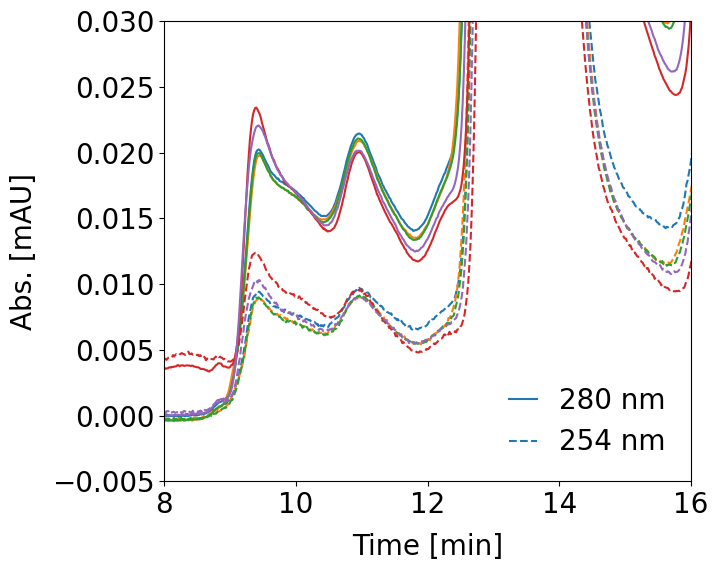

In [107]:
# Inspect the HCCF Feed SEC chromatograms

fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel='Abs. [mAU]')

i = 0
for s in sample_ids[-3:]:
    i += 1
    if i == 1:
        lab_1, lab_2 = '280 nm', '254 nm'
    else:
        lab_1, lab_2 = None, None
    ax.plot(data[s].df.time_min, data[s].df.uv_280, label = lab_1)
    ax.plot(data[s].df.time_min, data[s].df.uv_254, linestyle='--', label = lab_2, color=plt.gca().lines[-1].get_color())
       
for s in sample_ids_prev[-2:]:
    ax.plot(data_prev[s].df.time_min, data_prev[s].df.uv_280)
    ax.plot(data_prev[s].df.time_min, data_prev[s].df.uv_254, linestyle='--', color=plt.gca().lines[-1].get_color())
    
my_plot.set_layout(fig, ax, legend=True)

ax.set_xlim(8, 16)
ax.set_ylim(-0.005, 0.03)
# plt.savefig('./images/5_hccf_feed_254_280_zoomed.png', dpi=300, bbox_inches='tight')

# plt.savefig('./images/5_hccf_feed_254_280.png', dpi=300, bbox_inches='tight')

In [108]:
# # Inspect the HCCF Feed SEC chromatograms

# fig, ax = my_plot.instantiate_fig(x=8, xlabel='Time [min]', ylabel='A280 [mAU]')
# ax2 = my_plot.get_twinx(ax, ylabel = r'$A_{254}/A_{280}$')

# for s in sample_ids[-3:]:
#     ax.plot(data[s].df.time_min, data[s].df.uv_280)
#     ax2.plot(data[s].df.time_min, data[s].df.uv_254/data[s].df.uv_280, linestyle='--')
       
# for s in sample_ids_prev[-2:]:
#     ax.plot(data_prev[s].df.time_min, data_prev[s].df.uv_280)
#     ax2.plot(data_prev[s].df.time_min, data_prev[s].df.uv_254/data_prev[s].df.uv_280, linestyle='--')
    
# my_plot.set_layout(fig, ax, legend=True)

# # ax.set_xlim(9, 24)
# # ax2.set_ylim(0, 2)
# # plt.savefig('./images/5_hccf_feed_254_280_ratio.png', dpi=300, bbox_inches='tight')

# ax.set_ylim(-0.005, 0.07)
# ax.set_xlim(9, 18)
# ax2.set_ylim(0, 2)
# # plt.savefig('./images/5_hccf_feed_254_280_ratio_zoomed.png', dpi=300, bbox_inches='tight')

In [109]:
df_hccf_rep = data[sample_ids[-2]].df

## HCCF mass fractions 

In [110]:
# Get arrays of mass fraction (%) data from each run

percentages_254 = {'large':[], 'small':[], 'mab':[], 'lmw1':[], 'lmw2':[], 'lmw3':[]}
percentages_280 = {'large':[], 'small':[], 'mab':[], 'lmw1':[], 'lmw2':[], 'lmw3':[]}

for s in sample_ids[-3:]:
    for frac in percentages_254.keys():
        percentages_254[frac].append(data[s].percentages_254[frac])
        percentages_280[frac].append(data[s].percentages_280[frac])
for s in sample_ids_prev[-2:]:
    for frac in percentages_254.keys():
        percentages_254[frac].append(data_prev[s].percentages_254[frac])
        percentages_280[frac].append(data_prev[s].percentages_280[frac])
    
for frac in percentages_254.keys():
    percentages_254[frac] = np.array(percentages_254[frac])
    percentages_280[frac] = np.array(percentages_280[frac])

In [112]:
# Compute means of the replicate measurements and consolidate in a df
# Note that these may not sum to 100% because of the averaging order

wavelengths, fracs, mean_percent, rsd_percent = [], [], [], []

for frac in percentages_254.keys():
    wavelengths.append(254)
    fracs.append(frac)
    mean_percent.append(percentages_254[frac].mean())
    rsd_percent.append(np.std(percentages_254[frac], ddof=1)/percentages_254[frac].mean() * 100)
    
for frac in percentages_280.keys():
    wavelengths.append(280)
    fracs.append(frac)
    mean_percent.append(percentages_280[frac].mean())
    rsd_percent.append(np.std(percentages_280[frac], ddof=1)/percentages_280[frac].mean() * 100)
    
df_fracs_hccf = pd.DataFrame({'feed':'unprocessed_hccf', 'wavelength_nm':wavelengths, 'frac':fracs, 'mass_frac_mean_percent':mean_percent, 'rsd_percent':rsd_percent})

# PAFVIN

In [113]:
# Load HPLC data"
file_path = f'./hplc_data/2022-01-11_pafvin_feed/'
data, sample_ids = hplc.load_hplc_data(file_path, shift_baseline_time=5)

(8.0, 18.0)

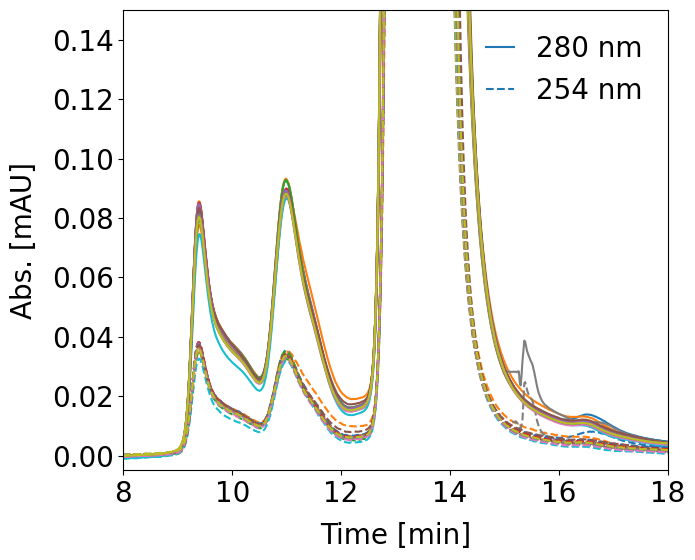

In [114]:
# Inspect the HCCF Feed SEC chromatograms

fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel='Abs. [mAU]')

i = 0
for s in sample_ids:
    i += 1
    if i == 1:
        lab_1, lab_2 = '280 nm', '254 nm'
    else:
        lab_1, lab_2 = None, None
    ax.plot(data[s].df.time_min, data[s].df.uv_280, label = lab_1)
    ax.plot(data[s].df.time_min, data[s].df.uv_254, linestyle='--', label = lab_2, color=plt.gca().lines[-1].get_color())
    
my_plot.set_layout(fig, ax, legend=True)

ax.set_ylim(-0.005, 0.15)
ax.set_xlim(8, 18)
# plt.savefig('./images/5_pafvin_feed_254_280_zoomed.png', dpi=300, bbox_inches='tight')

# plt.savefig('./images/5_pafvin_feed_254_280.png', dpi=300, bbox_inches='tight')

In [45]:
# # Inspect the HCCF Feed SEC chromatograms

# fig, ax = my_plot.instantiate_fig(x=8, xlabel='Time [min]', ylabel='A280 [mAU]')
# ax2 = my_plot.get_twinx(ax, ylabel = r'$A_{254}/A_{280}$')

# for s in sample_ids:
#     ax.plot(data[s].df.time_min, data[s].df.uv_280)
#     ax2.plot(data[s].df.time_min, data[s].df.uv_254/data[s].df.uv_280, linestyle='--')
    
# my_plot.set_layout(fig, ax, legend=True)

# ax.set_xlim(9, 15)
# ax.set_ylim(-0.005, 0.15)
# ax2.set_ylim(0, 2)
# # plt.savefig('./images/5_pafvin_feed_254_280_ratio_zoomed.png', dpi=300, bbox_inches='tight')

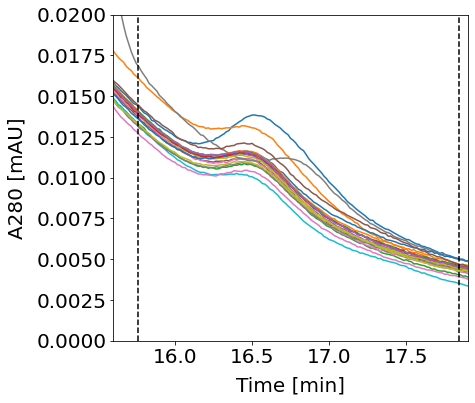

In [14]:
# Inspect the HCCF Feed SEC chromatograms

fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel='A280 [mAU]')

for s in sample_ids:
    ax.plot(data[s].df.time_min, data[s].df.uv_280)
    
for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]:
    ax.axvline(t, linestyle='--', color='black')
    
# ax.set_ylim(-0.005, 0.15)
# ax.set_xlim(8, 18)

ax.set_xlim(15.6, 17.9)
ax.set_ylim(0, 0.02)

my_plot.set_layout(fig, ax)

# plt.savefig('./images/5_pafvin_feed_lmw1_zoomed.png', dpi=300, bbox_inches='tight')

In [27]:
df_pafvin_rep = data[sample_ids[0]].df

## PAFVIN mass fractions

In [115]:
# Get arrays of mass fraction (%) data from each run

percentages_254 = {'large':[], 'small':[], 'mab':[], 'lmw1':[], 'lmw2':[], 'lmw3':[]}
percentages_280 = {'large':[], 'small':[], 'mab':[], 'lmw1':[], 'lmw2':[], 'lmw3':[]}

for s in sample_ids:
    for frac in percentages_254.keys():
        percentages_254[frac].append(data[s].percentages_254[frac])
        percentages_280[frac].append(data[s].percentages_280[frac])
    
for frac in percentages_254.keys():
    percentages_254[frac] = np.array(percentages_254[frac])
    percentages_280[frac] = np.array(percentages_280[frac])

In [116]:
# Compute means of the replicate measurements and consolidate in a df
# Note that these may not sum to 100% because of the averaging order

wavelengths, fracs, mean_percent, rsd_percent = [], [], [], []

for frac in percentages_254.keys():
    wavelengths.append(254)
    fracs.append(frac)
    mean_percent.append(percentages_254[frac].mean())
    rsd_percent.append(np.std(percentages_254[frac], ddof=1)/percentages_254[frac].mean() * 100)
    
for frac in percentages_280.keys():
    wavelengths.append(280)
    fracs.append(frac)
    mean_percent.append(percentages_280[frac].mean())
    rsd_percent.append(np.std(percentages_280[frac], ddof=1)/percentages_280[frac].mean() * 100)
    
df_fracs_pafvin = pd.DataFrame({'feed':'unprocessed_pafvin', 'wavelength_nm':wavelengths, 'frac':fracs, 'mass_frac_mean_percent':mean_percent, 'rsd_percent':rsd_percent})

# HCCF vs. PAFVIN

In [51]:
for df in [df_hccf_rep, df_pafvin_rep]:
    df['volume_ml'] = 0.6 * df.time_min

In [47]:
v_quant = 0.6*np.array([8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45, 24.7]) # used in analytical quantification
df_hccf_all_fracs = akta.load_and_clean_xls('../2022-01-19_psuedo_prep_sec/data/CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 2 07.xls')
v_frac = df_hccf_all_fracs[:8].fractions_ml.values # used in preparative fractionation

In [68]:
abs_max = []
for v in v_quant:
    index = df_hccf_rep.iloc[(df_hccf_rep.volume_ml - v).abs().argsort()].index[0]
    abs_hccf = df_hccf_rep.at[index, 'uv_280']
    index = df_pafvin_rep.iloc[(df_pafvin_rep.volume_ml - v).abs().argsort()].index[0]
    abs_pafvin = df_pafvin_rep.at[index, 'uv_280']
    abs_max.append(max(abs_hccf, abs_pafvin))
abs_min = np.ones(len(abs_max)) * -0.01

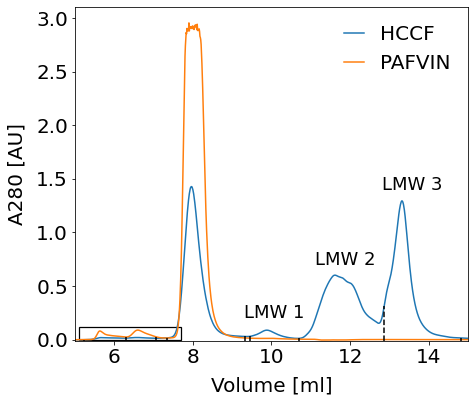

In [102]:
fig, ax = my_plot.instantiate_fig(xlabel='Volume [ml]', ylabel='A280 [AU]')
ax.plot(df_hccf_rep.time_min * 0.6, df_hccf_rep.uv_280, label='HCCF')
ax.plot(df_pafvin_rep.time_min * 0.6, df_pafvin_rep.uv_280, label='PAFVIN')

ax.vlines(v_quant, abs_min, abs_max, color='black', linestyle='--')
my_plot.set_layout(fig, ax, legend=True)

ax.set_xlim(5, 15)
ax.set_ylim(-0.01, None)

t = ax.annotate('LMW 1', xytext=(9.3, 0.2), xy=(6, 0.05), fontsize=18)
t = ax.annotate('LMW 2', xytext=(11.1, 0.7), xy=(6, 0.05), fontsize=18)
t = ax.annotate('LMW 3', xytext=(12.8, 1.4), xy=(6, 0.05), fontsize=18)

ax.add_patch(Rectangle((5.1, 0), 7.7-5.1, 0.12, fill=False, edgecolor='black', lw=1.25))

plt.savefig('./images/5_hccf_vs_pafvin_feed_unprocessed.png', dpi=300, bbox_inches='tight')

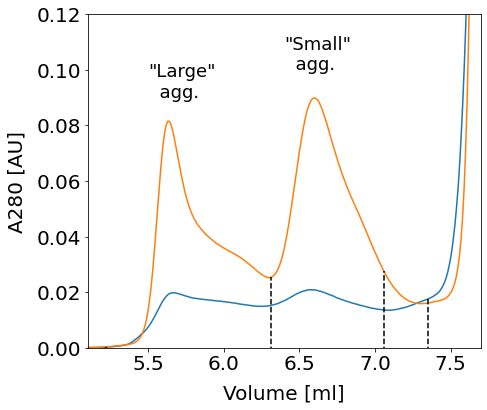

In [103]:
fig, ax = my_plot.instantiate_fig(xlabel='Volume [ml]', ylabel='A280 [AU]')
ax.plot(df_hccf_rep.time_min * 0.6, df_hccf_rep.uv_280, label='HCCF')
ax.plot(df_pafvin_rep.time_min * 0.6, df_pafvin_rep.uv_280, label='PAFVIN')

ax.vlines(v_quant, abs_min, abs_max, color='black', linestyle='--')
my_plot.set_layout(fig, ax, legend=False)

ax.set_xlim(5.1, 7.7)
ax.set_ylim(0, 0.12)

ax.annotate('"Large"\n  agg.', xytext=(5.5, 0.09), xy=(6, 0.05), fontsize=18)
ax.annotate('"Small"\n  agg.', xytext=(6.4, 0.10), xy=(6, 0.05), fontsize=18)

plt.savefig('./images/5_hccf_vs_pafvin_feed_unprocessed_zoomed.png', dpi=300, bbox_inches='tight')

# PAFVIN diluted mass fractions

In [103]:
df_x_150, data_x_150, sample_ids_x_150, df_areas_x_150, df_norm_all_x_150, df_norm_x_150, df_cip_x_150, feed_areas_x_150 =\
hplc.get_data('./Akta_data/2022-08-18_AEX_FT_poros_xq.csv', './hplc_data/2022-08-19_AEX_FT_XQ/')

df_c_150, data_c_150, sample_ids_c_150, df_areas_c_150, df_norm_all_c_150, df_norm_c_150, df_cip_c_150, feed_areas_c_150 =\
hplc.get_data('./Akta_data/2022-08-19_AEX_FT_capto_q.csv', './hplc_data/2022-08-21_AEX_FT_CQ/')

df_h_150, data_h_150, sample_ids_h_150, df_areas_h_150, df_norm_all_h_150, df_norm_h_150, df_cip_h_150, feed_areas_h_150 =\
hplc.get_data('./Akta_data/2022-08-21_AEX_FT_poros_50_hq.csv', './hplc_data/2022-08-23_AEX_FT_HQ/')

df_x_30, data_x_30, sample_ids_x_30, df_areas_x_30, df_norm_all_x_30, df_norm_x_30, feed_areas_x_30 =\
hplc.get_data('./Akta_data/2022-08-23_AEX_only_FT_poros_xq_30_cm_h_2.csv', './hplc_data/2022-08-25_AEX_FT_XQ_30/', cip=False, start_index=6)

df_c_30, data_c_30, sample_ids_c_30, df_areas_c_30, df_norm_all_c_30, df_norm_c_30, feed_areas_c_30 =\
hplc.get_data('./Akta_data/2022-08-24_AEX_only_FT_CQ_30_cm_h.csv', './hplc_data/2022-08-26_AEX_FT_CQ_30/', cip=False, start_index=6)

df_h_30, data_h_30, sample_ids_h_30, df_areas_h_30, df_norm_all_h_30, df_norm_h_30, feed_areas_h_30 =\
hplc.get_data('./Akta_data/2022-08-26_AEX_only_FT_poros_50_hq_30_cm_h.csv', './hplc_data/2022-08-27_AEX_FT_HQ_30/', cip=False, start_index=6)

/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixe

In [117]:
percentages_254 = {'large':[], 'small':[], 'mab':[], 'lmw1':[], 'lmw2':[], 'lmw3':[]}
percentages_280 = {'large':[], 'small':[], 'mab':[], 'lmw1':[], 'lmw2':[], 'lmw3':[]}

all_data = [data_c_150, data_x_150, data_h_150, data_c_30, data_x_30, data_h_30]
all_ids = [sample_ids_c_150, sample_ids_x_150, sample_ids_h_150, 
           sample_ids_c_30, sample_ids_x_30, sample_ids_h_30]

for data, sample_ids in zip(all_data, all_ids):
    sample_subset_ids = [s for s in sample_ids if 'PAFVIN' in s]
    for s in sample_subset_ids:
        for frac in percentages_254.keys():
            percentages_254[frac].append(data[s].percentages_254[frac])
            percentages_280[frac].append(data[s].percentages_280[frac])
            
for frac in percentages_254.keys():
    percentages_254[frac] = np.array(percentages_254[frac])
    percentages_280[frac] = np.array(percentages_280[frac])

In [118]:
# Compute means of the replicate measurements and consolidate in a df
# Note that these may not sum to 100% because of the averaging order

wavelengths, fracs, mean_percent, rsd_percent = [], [], [], []

for frac in percentages_254.keys():
    wavelengths.append(254)
    fracs.append(frac)
    mean_percent.append(percentages_254[frac].mean())
    rsd_percent.append(np.std(percentages_254[frac], ddof=1)/percentages_254[frac].mean() * 100)
    
for frac in percentages_280.keys():
    wavelengths.append(280)
    fracs.append(frac)
    mean_percent.append(percentages_280[frac].mean())
    rsd_percent.append(np.std(percentages_280[frac], ddof=1)/percentages_280[frac].mean() * 100)
    
df_fracs_pafvin_diluted = pd.DataFrame({'feed':'diluted_pafvin', 'wavelength_nm':wavelengths, 'frac':fracs, 'mass_frac_mean_percent':mean_percent, 'rsd_percent':rsd_percent})

In [119]:
df_fracs_percent = pd.concat([df_fracs_hccf, df_fracs_pafvin, df_fracs_pafvin_diluted], ignore_index=True)
df_fracs_percent.to_csv('./feedstock_component_fractions.csv', index=False)